In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt


from numpy import genfromtxt
import datetime

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix, constraintASparse, plotSwitches, setupAxis

from model_loader import *
from price_loader import *
from color_loader import *

import switching_times_1st as st1
import switching_times_1st as st2

def plotSwitches(switches,t0,c1,c2,ax):
    n_s = int(len(switches)/2)
    for xc in switches[:n_s]:
        ax.axvline(x=xc+t0,color = c1, alpha = 0.2)
    
    for xc in switches[n_s:]:
        ax.axvline(x=xc+t0,color = c2, alpha = 0.2)

def modification_date(filename):
    t = os.path.getmtime(filename)
    return datetime.datetime.fromtimestamp(t)

import matplotlib.patches as mpatches
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


import seaborn as sns


%load_ext autoreload
%autoreload 2


/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


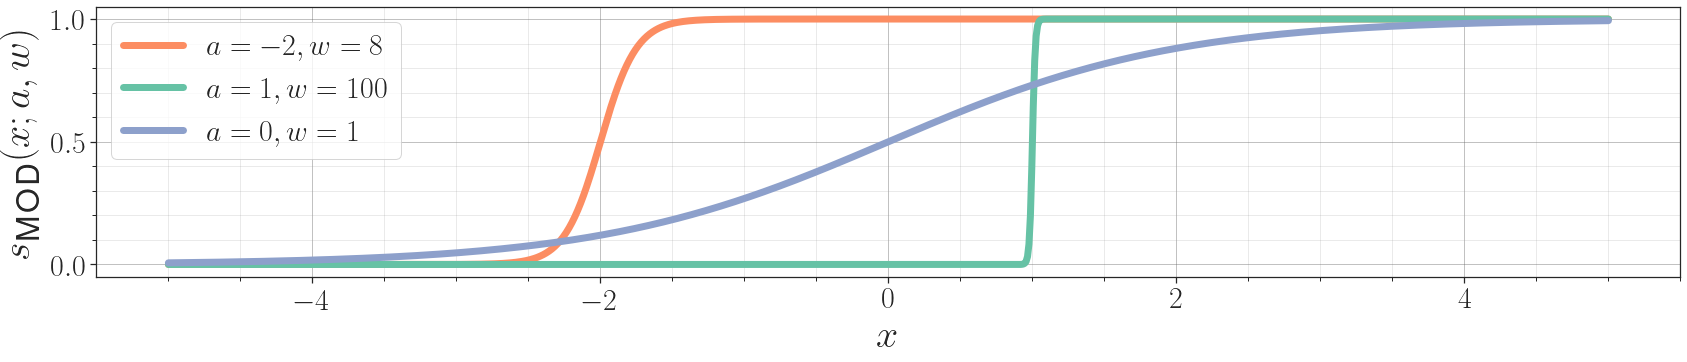

In [4]:
slope = 100.
t = np.linspace(-5,5,1000)
_dap = 0

slope_normal = 1
normal = 1 / ((1. + np.exp(np.minimum(-slope_normal * (t - 0), 15.0 ))))

slope1 = 100
offset1 = 1
up = 1 / ((1. + np.exp(np.minimum(-slope1 * (t - offset1), 15.0 ))))

slope2 = 8
offset2 = -2
down = 1 / ((1. + np.exp(np.minimum(-slope2 * (t - offset2), 15.0 ))))

fig = plt.figure(figsize = (25,5))
ax = fig.add_subplot(111)
ax.plot(t,down, label=r'$a = {}, w = {}$'.format(offset2,slope2),color=sns.color_palette("Set2")[1],linewidth=7)
ax.plot(t,up, label=r'$a = {}, w = {}$'.format(offset1,slope1),color=sns.color_palette("Set2")[0],linewidth=7)
ax.plot(t,normal, label=r'$a = {}, w = {}$'.format(0,1),color=sns.color_palette("Set2")[2],linewidth=7)




setupAxis(ax)
ax.set_xlabel(r'$x$',size = 40)
plt.subplots_adjust(bottom = 0.2)
ax.set_ylabel(r'$s_{\textsc{mod}}(x;a,w)$',size = 40)

plt.subplots_adjust(hspace = 0.,bottom=0.2, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/control/sigmoids.pdf',format='pdf')

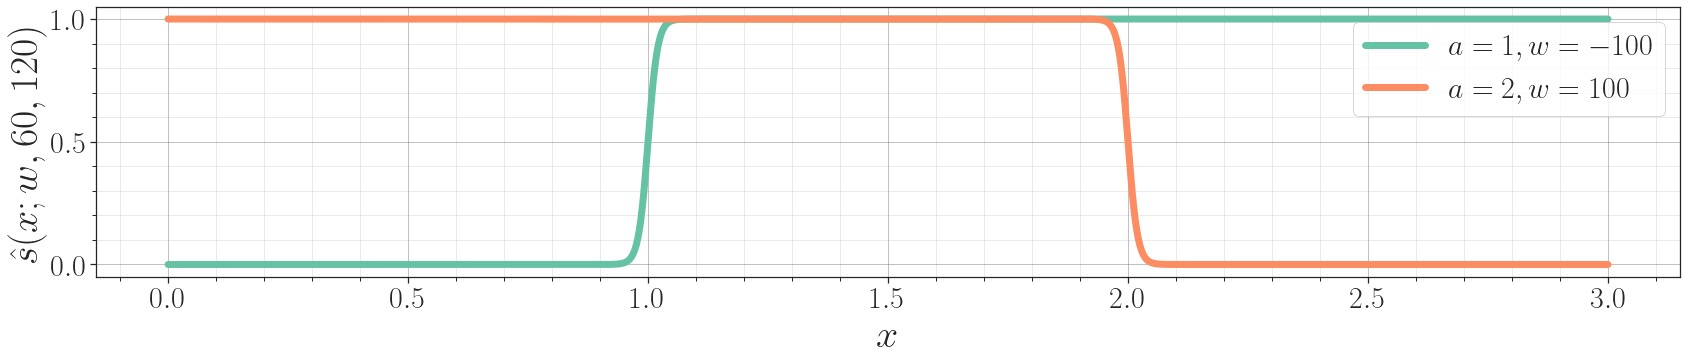

In [5]:
slope = 100.
t = np.linspace(0,3,1000)
_dap = 0
up = 1 / ((1. + np.exp(np.minimum(-slope * (t - 1), 15.0 ))))
down = 1 / ((1. + np.exp(np.minimum(slope * (t - 2), 15.0 ))))
#plt.plot(t,_dap)
fig = plt.figure(figsize = (25,5))
ax = fig.add_subplot(111)
linewidth = 7
ax.plot(t,up, label=r'$a = {}, w = {}$'.format(1,-100),color=sns.color_palette("Set2")[0],linewidth=linewidth)
ax.plot(t,down, label=r'$a = {}, w = {}$'.format(2,100),color=sns.color_palette("Set2")[1],linewidth=linewidth)
setupAxis(ax,ncol_legend=1)
ax.set_xlabel(r'$x$',size = 40)
plt.subplots_adjust(bottom = 0.2)
ax.set_ylabel(r'$\hat s(x;w,60,120)$',size = 40)

plt.subplots_adjust(hspace = 0.,bottom=0.2, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/control/sigmoids_flip.pdf',format='pdf')

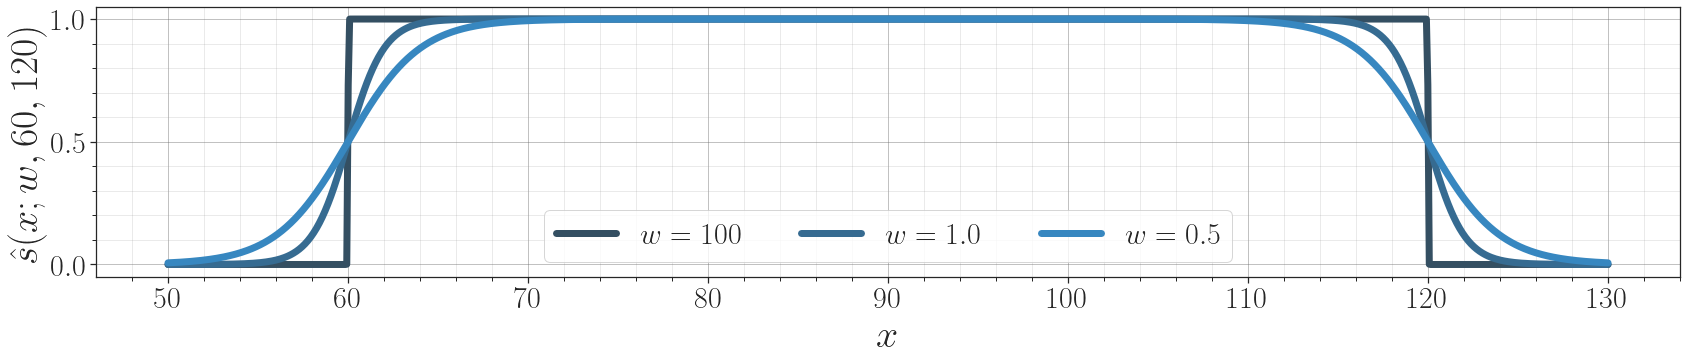

In [6]:
t = np.linspace(50,130,1000)

slope1 = 0.5
_dap1 = 1 / ((1. + np.exp(np.minimum(-slope1 * (t - 60), 15.0 ))) *
                 (1. + np.exp( np.minimum(slope1 * (t - 120), 15.))))

slope2 = 1.
_dap2 = 1 / ((1. + np.exp(np.minimum(-slope2 * (t - 60), 15.0 ))) *
                 (1. + np.exp( np.minimum(slope2 * (t - 120), 15.))))

slope3 = 100.
_dap3 = 1 / ((1. + np.exp(np.minimum(-slope3 * (t - 60), 15.0 ))) *
                 (1. + np.exp( np.minimum(slope3 * (t - 120), 15.))))
fig = plt.figure(figsize = (25,5))
ax = fig.add_subplot(111)
linewidth = 7
ax.plot(t,_dap3, label=r'$w = {}$'.format(int(slope3)),color = blue[0],linewidth=linewidth)
ax.plot(t,_dap2, label=r'$w = {}$'.format(slope2),color = blue[1],linewidth=linewidth)
ax.plot(t,_dap1, label=r'$w = {}$'.format(slope1),color = blue[2],linewidth=linewidth)


setupAxis(ax,ncol_legend=3)
ax.set_xlabel(r'$x$',size = 40)
ax.set_ylabel(r'$\hat s(x;w,60,120)$',size = 40)
plt.subplots_adjust(bottom = 0.2)
#ax.set_ylim(-0.01, 2.01)

plt.subplots_adjust(hspace = 0.,bottom=0.2, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/control/step.pdf',format='pdf')

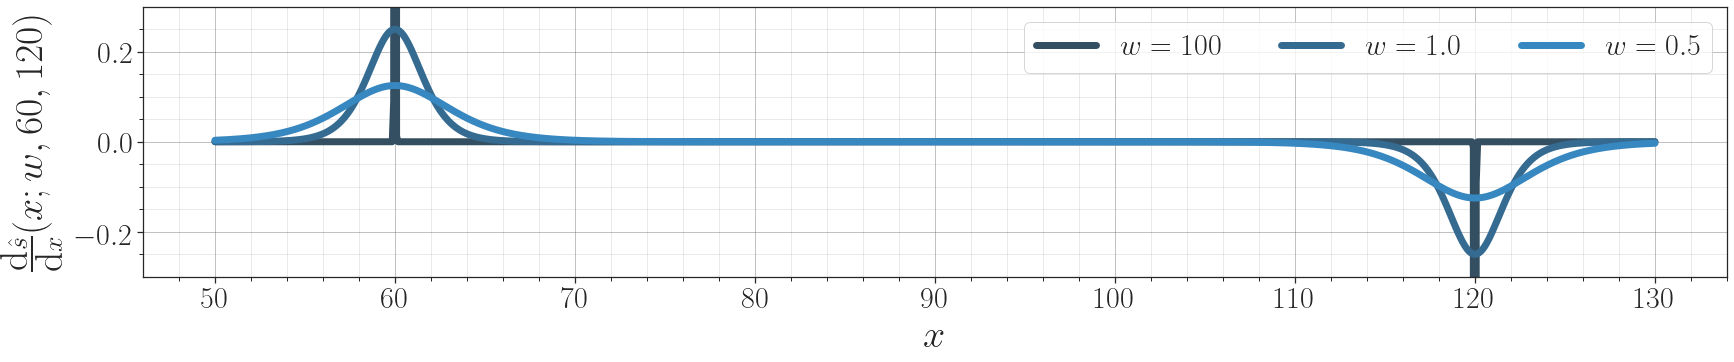

In [7]:
w = slope1
ds1 = w*np.exp(np.minimum(-w*(t - 60),15.))/((1. + np.exp(np.minimum(-w*(t - 60),15.)))**2*(1. + np.exp(np.minimum(w*(t - 120),15.)))) - w*np.exp(np.minimum(w*(t - 120),15.))/((1. + np.exp(np.minimum(-w*(t - 60),15.)))*(1. + np.exp(np.minimum(w*(t - 120),15.)))**2)

w = slope2
ds2 = w*np.exp(np.minimum(-w*(t - 60),15.))/((1. + np.exp(np.minimum(-w*(t - 60),15.)))**2*(1. + np.exp(np.minimum(w*(t - 120),15.)))) - w*np.exp(np.minimum(w*(t - 120),15.))/((1. + np.exp(np.minimum(-w*(t - 60),15.)))*(1. + np.exp(np.minimum(w*(t - 120),15.)))**2)

w = slope3
ds3 = w*np.exp(np.minimum(-w*(t - 60),15.))/((1. + np.exp(np.minimum(-w*(t - 60),15.)))**2*(1. + np.exp(np.minimum(w*(t - 120),15.)))) - w*np.exp(np.minimum(w*(t - 120),15.))/((1. + np.exp(np.minimum(-w*(t - 60),15.)))*(1. + np.exp(np.minimum(w*(t - 120),15.)))**2)

fig = plt.figure(figsize = (25,5))
ax = fig.add_subplot(111)
linewidth = 7

ax.plot(t,ds3, label=r'$w = {}$'.format(int(slope3)),color = blue[0],linewidth=linewidth)
ax.plot(t,ds2, label=r'$w = {}$'.format(slope2),color = blue[1],linewidth=linewidth)
ax.plot(t,ds1, label=r'$w = {}$'.format(slope1),color = blue[2],linewidth=linewidth)

setupAxis(ax,ncol_legend=3)
ax.set_xlabel(r'$x$',size = 40)
ax.set_ylabel(r'$\frac{\textnormal{d}\hat s}{\textnormal{d}x}(x;w,60,120)$',size = 40)
ax.set_ylim(-0.3,0.3)
plt.subplots_adjust(bottom = 0.2)
#ax.set_ylim(-0.01, 2.01)

plt.subplots_adjust(hspace = 0.,bottom=0.2, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/control/deriv_step.pdf',format='pdf')


# Price time series

0.6432693752935681


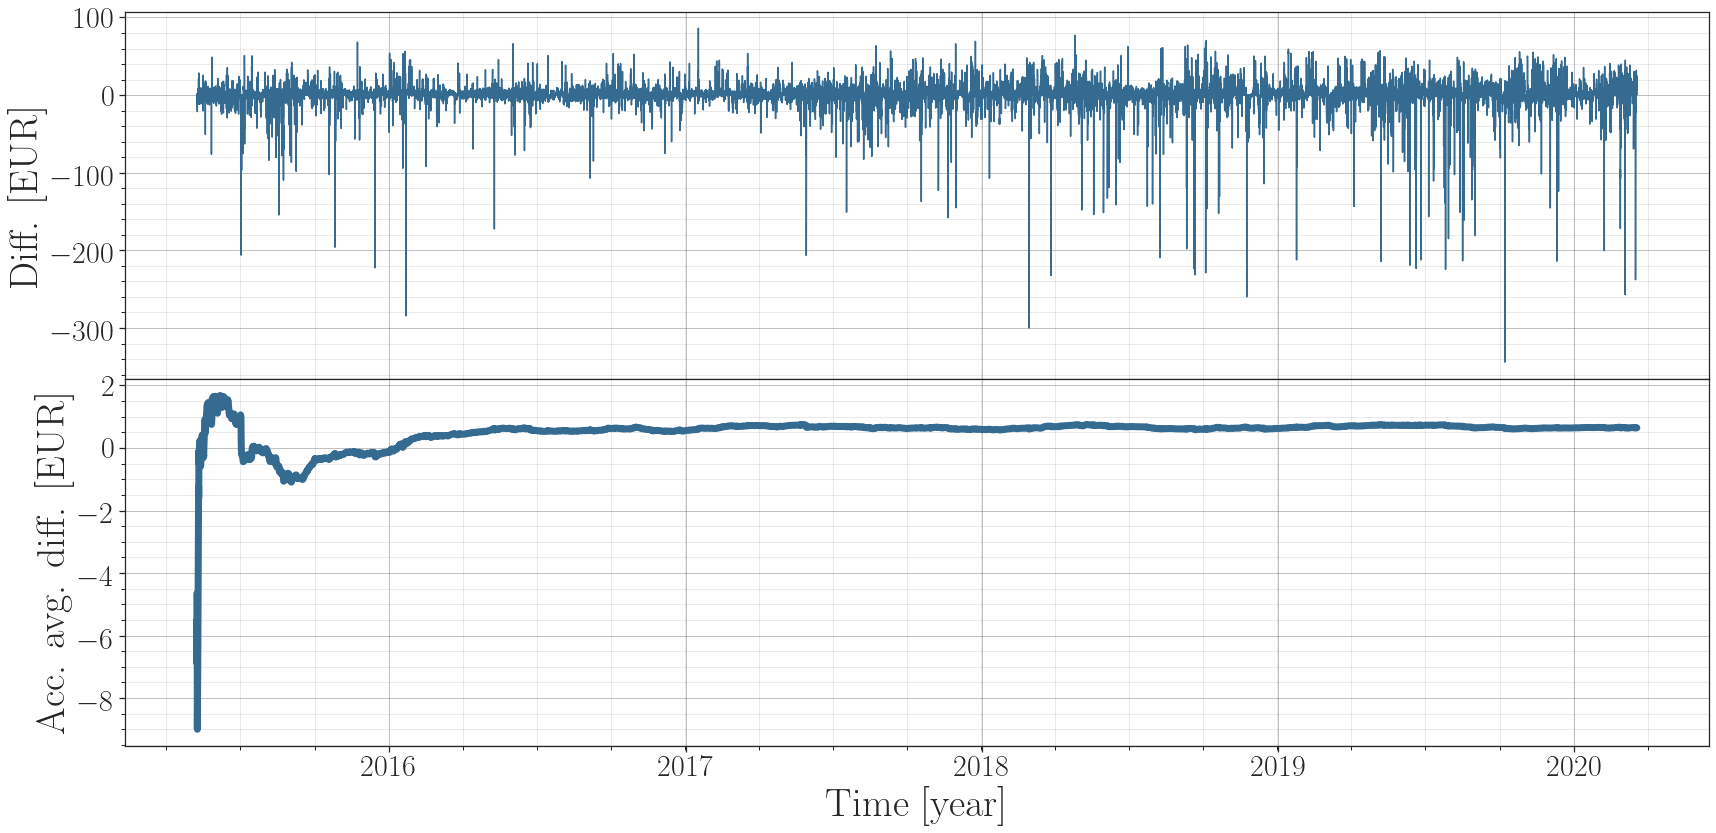

In [11]:
print(np.mean(prices['spot'] - prices['RK']))

fig = plt.figure(figsize = (25,12))
ax = fig.add_subplot(211)
ax.plot(prices['spot'] - prices['RK'],color=blue[1])

setupAxis(ax,nolegend=True)
ax.set_xlabel(r'$\textnormal{Time [year]}$')
ax.set_ylabel(r'$\textnormal{Diff. [EUR]}$')
ax.set_xticklabels([r'$\textnormal{2015}$',r'$\textnormal{2016}$', r'$\textnormal{2017}$',r'$\textnormal{2018}$',r'$\textnormal{2019}$',r'$\textnormal{2020}$'])


#plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)


ax = fig.add_subplot(212)

pricediff = prices['spot'] - prices['RK']
n = pricediff.shape[0]
ax.plot(1/np.arange(1,n+1) * np.cumsum(pricediff),linewidth=7,color=blue[1])
setupAxis(ax,nolegend=True)
ax.set_ylabel(r'$\textnormal{Acc. avg. diff. [EUR]}$')
ax.set_xticklabels([r'$\textnormal{2015}$',r'$\textnormal{2016}$', r'$\textnormal{2017}$',r'$\textnormal{2018}$',r'$\textnormal{2019}$',r'$\textnormal{2020}$'])
ax.set_xlabel(r'$\textnormal{Time [year]}$')



plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/price_differences.pdf',format='pdf')


# Sketch switching time problem in loss

54290.625
2500.0


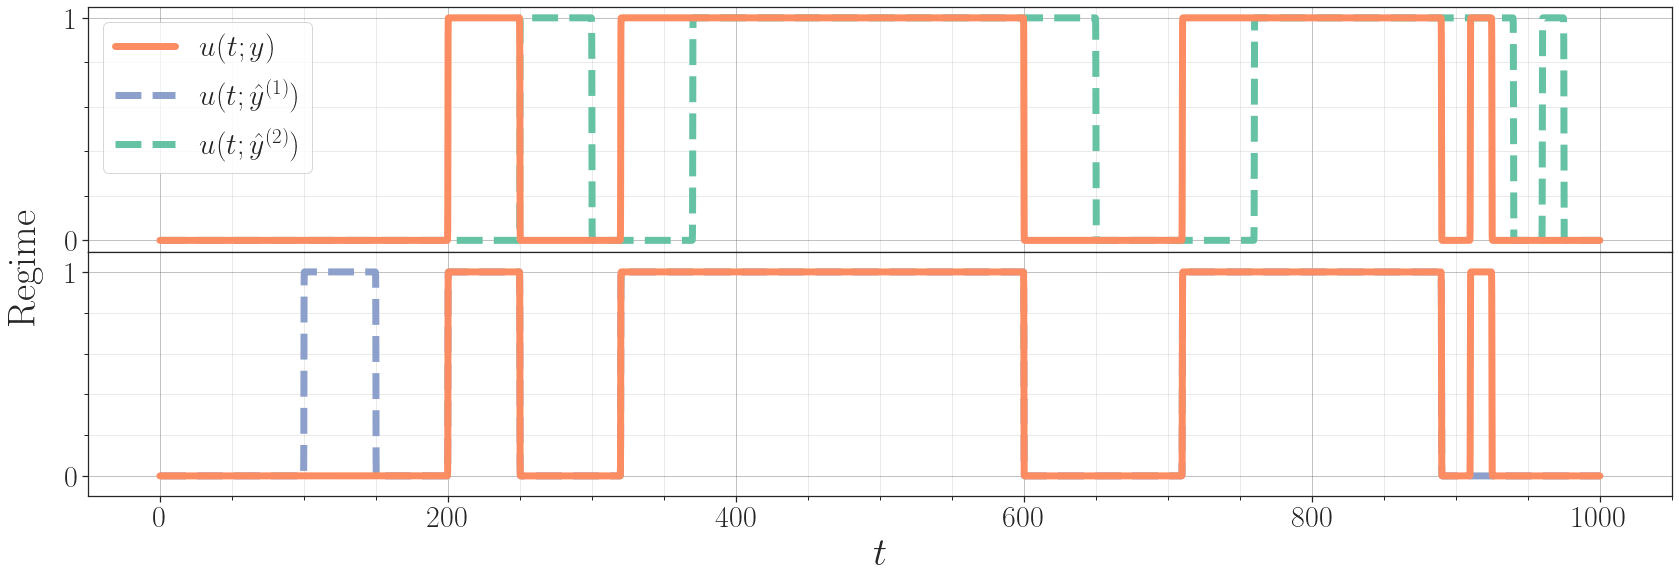

In [6]:
fig = plt.figure(figsize = (25,8))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
T = np.linspace(0,1000,10000)
s_true = np.array([200,320,710,910,250,600,890,925])
s1 = np.array([100,200,320,710,150,250,600,890])
s2 = s_true + 50
linewidth=7


pred2 = ax1.plot(T,smooth_regime(T,s2),color = sns.color_palette("Set2")[0],linestyle='--',label=r'$u\Bigg(t;\hat y^{(2)}\Bigg)$',linewidth=linewidth)
target1 = ax1.plot(T,smooth_regime(T,s_true),color = sns.color_palette("Set2")[1],label=r'$u(t;y)$',linewidth=linewidth)
setupAxis(ax1)
ax1.set_xlabel(r'')
ax1.set_xticklabels([''])
ax1.set_yticks(np.array([0,1]))
ax1.set_ylabel(r'')
#ax1.set_ylabel(r'$u(t)$')

pred1 = ax2.plot(T,smooth_regime(T,s1),color = sns.color_palette("Set2")[2],linestyle='--',label=r'$u\Bigg(t;\hat y^{(1)}\Bigg)$',linewidth=linewidth)
ax2.plot(T,smooth_regime(T,s_true),color = sns.color_palette("Set2")[1],label=r'$\textnormal{Target}$',linewidth=linewidth)
setupAxis(ax2,nolegend=True)
ax2.set_yticks(np.array([0,1]))
ax2.set_ylim(-0.1,1.1)
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'')

lns = target1 + pred1+ pred2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs,ncol=1,prop={'size': 30})

fig.text(0.035, 0.5, r'$\textnormal{Regime}$', va='center', ha='center', rotation='vertical', fontsize=40)
plt.subplots_adjust(hspace = 0.)#,bottom=0.05, top =0.95)

print(np.mean((s1 - s_true)**2))
print(np.mean((s2 - s_true)**2))

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/ann/shifted_preds.pdf',format='pdf')

In [7]:
def my_loss(output, target):
    n_s = int(len(target)/2)
    x = np.linspace(0, 1000, 1000)
    dt = x[2] - x[1]

    pred_switch_torch =(2*1440)*output
    gt_switch_torch =(2*1440)*target
    tau_MELT = output[:n_s]
    tau_IDLE = output[n_s:]
    tau_MELT_gt = target[:n_s]
    tau_IDLE_gt = target[n_s:]

    #tau_MELT, tau_IDLE  = pred_switch_torch[:n_s] , pred_switch_torch[n_s:] #derive_regimes(switches,T[-1],0)
    regime = 0
    regime_gt = 0
    for k in range(n_s):
            regime += 1/ ((1 + np.exp(np.minimum(-1* (x - tau_MELT[k]), 15.0 ))) *
                             (1 + np.exp( np.minimum(1* (x - tau_IDLE[k]),  15.0))))

            regime_gt += 1/ ((1 + np.exp(np.minimum(-1* (x - tau_MELT_gt[k]),15.0 ))) *
                             (1 + np.exp( np.minimum(1* (x - tau_IDLE_gt[k]),  15.0))))

    #loss = torch.sum(torch.pow(output - target,2))
    loss =np.sum(np.power(regime - regime_gt,2) * dt)
    
    return loss

def plot_loss(output, target,col=None):
    n_s = int(len(target)/2)
    x = np.linspace(0, 1000, 1000)
    dt = x[2] - x[1]

    pred_switch_torch =(2*1440)*output
    gt_switch_torch =(2*1440)*target
    tau_MELT = output[:n_s]
    tau_IDLE = output[n_s:]
    tau_MELT_gt = target[:n_s]
    tau_IDLE_gt = target[n_s:]

    #tau_MELT, tau_IDLE  = pred_switch_torch[:n_s] , pred_switch_torch[n_s:] #derive_regimes(switches,T[-1],0)
    regime = 0
    regime_gt = 0
    for k in range(n_s):
            regime += 1/ ((1 + np.exp(np.minimum(-1* (x - tau_MELT[k]), 15.0 ))) *
                             (1 + np.exp( np.minimum(1* (x - tau_IDLE[k]),  15.0))))

            regime_gt += 1/ ((1 + np.exp(np.minimum(-1* (x - tau_MELT_gt[k]),15.0 ))) *
                             (1 + np.exp( np.minimum(1* (x - tau_IDLE_gt[k]),  15.0))))

    #loss = torch.sum(torch.pow(output - target,2))
    line = plt.plot(np.power(regime - regime_gt,2) * dt,color=col)
    loss = np.cumsum(np.power(regime - regime_gt,2) * dt)
    
    return line, loss

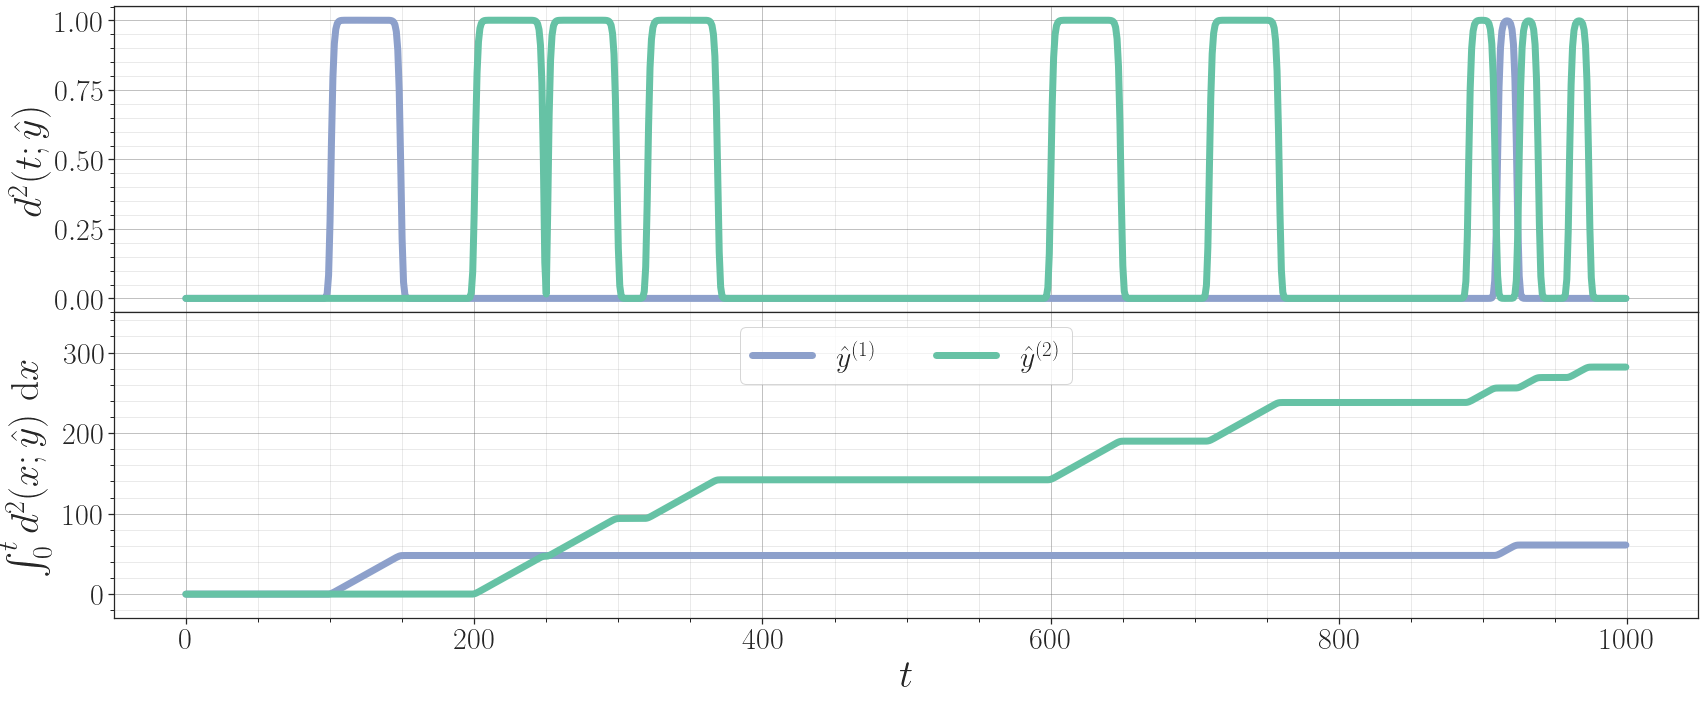

In [25]:
fig = plt.figure(figsize = (25,10))
ax1 = fig.add_subplot(211)

l1, loss1 = plot_loss(s1,s_true)
l2, loss2 = plot_loss(s2,s_true)
ax1.lines[0].set_color(sns.color_palette("Set2")[2])
ax1.lines[0].set_label(r'$\hat y^{(1)}$')
ax1.lines[1].set_color(sns.color_palette("Set2")[0])
ax1.lines[1].set_label(r'$\hat y^{(2)}$')
for line in ax1.lines:
    line.set_linewidth(linewidth)
    
setupAxis(ax1,nolegend = True)
ax1.set_ylabel(r'$d^2(t;\hat y)$',size=40)
ax1.set_xlabel(r'$t$')


ax2 = fig.add_subplot(212)
ax2.plot(loss1)
ax2.plot(loss2)
ax2.lines[0].set_color(sns.color_palette("Set2")[2])
ax2.lines[0].set_label(r'$\hat y^{(1)}$')
ax2.lines[1].set_color(sns.color_palette("Set2")[0])
ax2.lines[1].set_label(r'$\hat y^{(2)}$')
for line in ax2.lines:
    line.set_linewidth(linewidth)
    
setupAxis(ax2)
ax2.set_ylabel(r'$\int_0^t d^2(x;\hat y) \textnormal{ d}x $',size=40)
ax2.set_xlabel(r'$t$',size=40)
ax2.set_ylim(-30,350)

plt.subplots_adjust(hspace = 0.)

    
ax2.legend(prop={'size': 30},ncol=2,loc = 'upper center')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
    
plt.savefig(FIGS + '/ann/shifted_preds_area.pdf',format='pdf')

# Prices

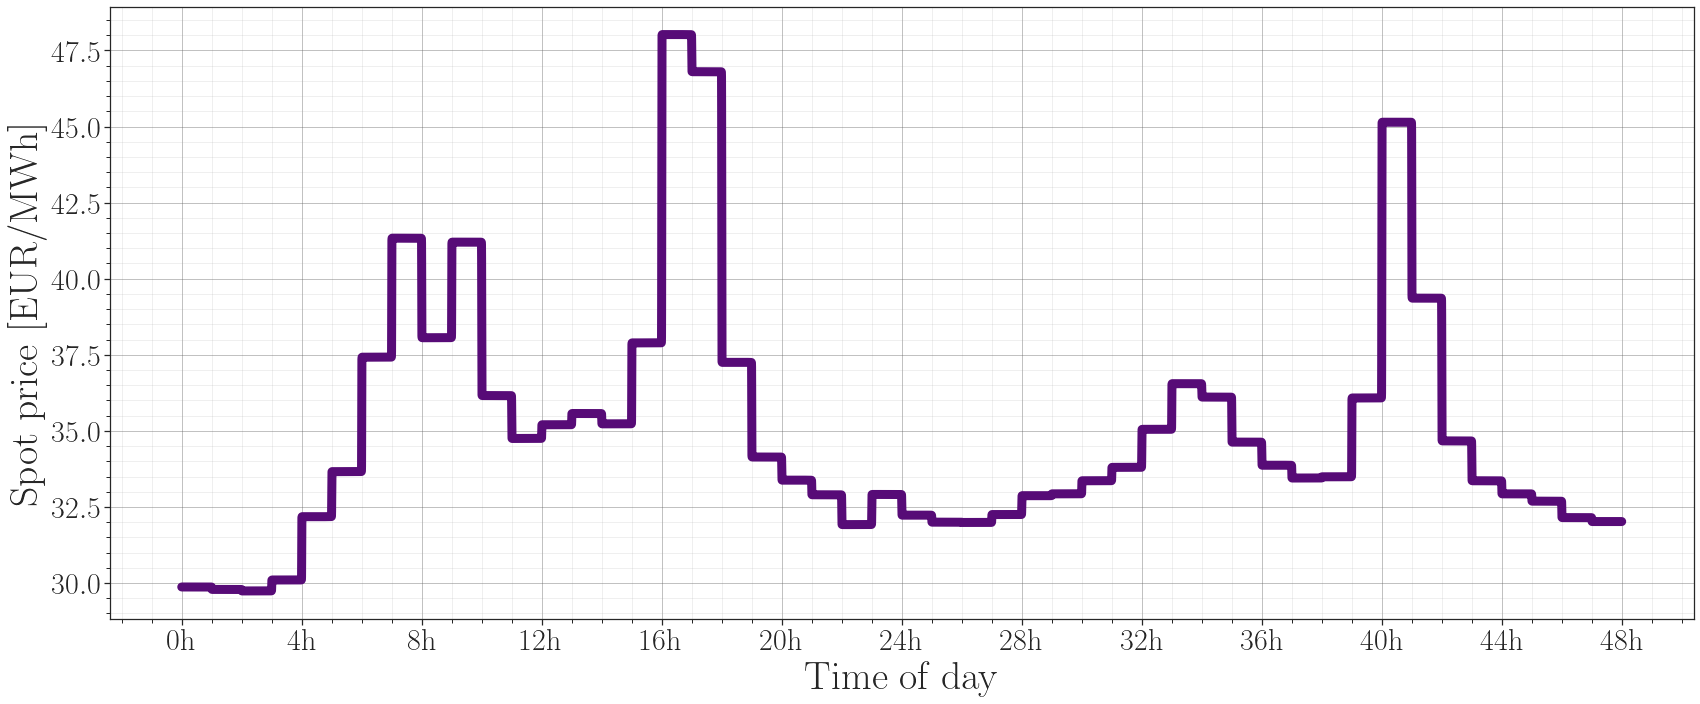

In [6]:
prices_plot = prices['2018-02-02  00:00:00':'2018-02-03  23:00:00']
T_price = 0.1 * np.arange(1,prices_plot.shape[0] * 60/0.1)
day_skip = 2
fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(111)

ax.plot(T_price,smooth_dap(T_price,prices_plot['spot'],slope=10,n_hours=48),color='#570b77',linewidth=9)
setupAxis(ax,nolegend=True)

ax.set_xticks(np.arange(0,49,4)*(60.) )
#ax.set_yticks(np.arange(5,11,1)*(0.1), ) 
#ax.set_yticklabels(['$'+str(int(val)) + '$' for val in np.arange(50,110,10)]) 
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,49,4) * 60.])
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Spot price [EUR/MWh]}$',size = 40)
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.15)
#ax.set_ylim(22.682453002807346, 52.33851609850656)
#ax.legend(prop={'size': 25},ncol=1,loc = 'lower right')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/market/spot_price.pdf',format='pdf')



No handles with labels found to put in legend.


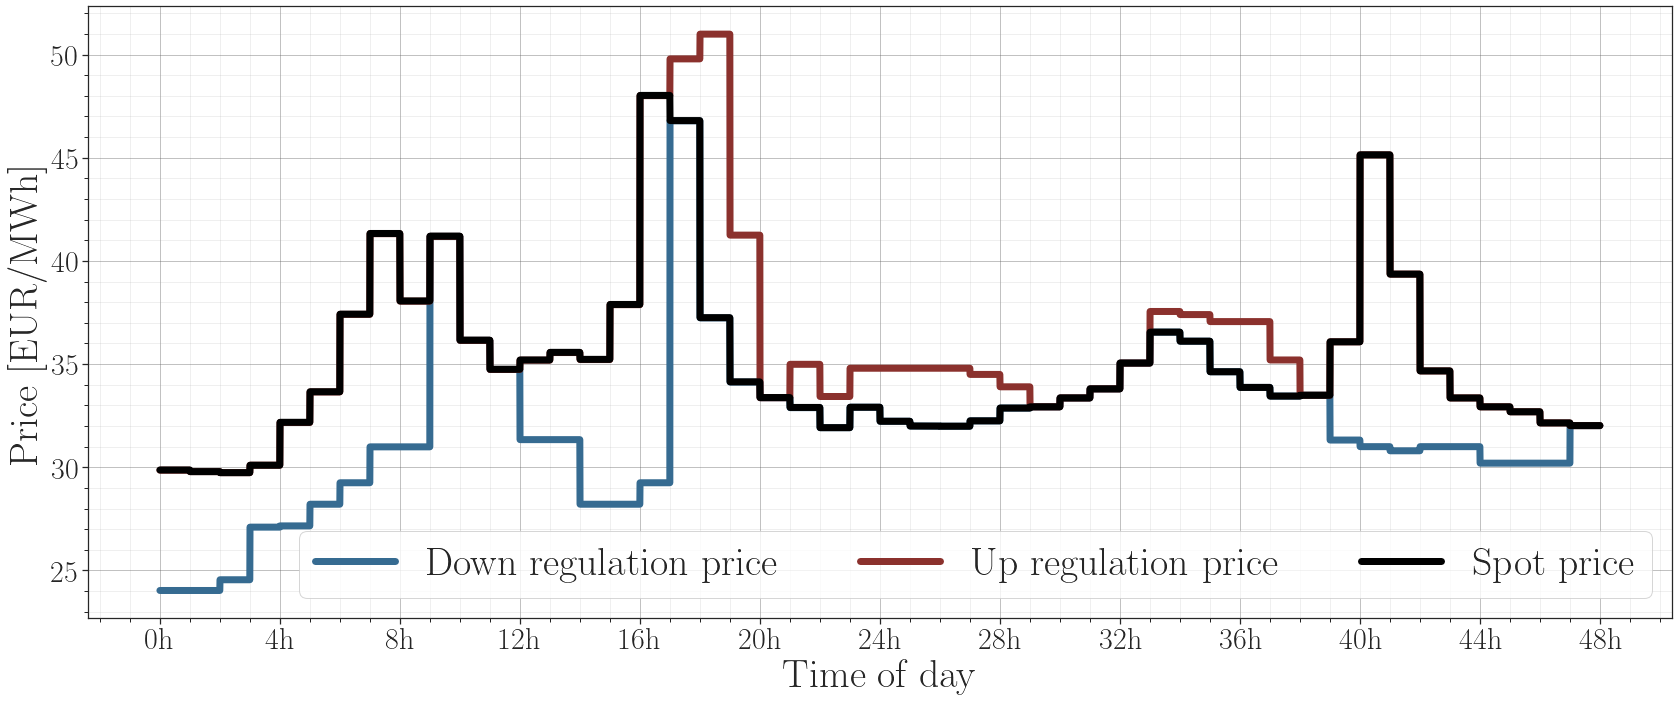

In [29]:
prices_plot = prices['2018-02-02  00:00:00':'2018-02-03  23:00:00']
T_price = 0.1 * np.arange(1,prices_plot.shape[0] * 60/0.1)
day_skip = 2
fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(111)

setupAxis(ax)
ax.plot(T_price,smooth_dap(T_price,prices_plot['down'],slope=100,n_hours=48),color=blue[1],linewidth=7,label=r'$\textnormal{Down regulation price}$')
ax.plot(T_price,smooth_dap(T_price,prices_plot['up'],slope=100,n_hours=48),color=red[1],linewidth=7,label=r'$\textnormal{Up regulation price}$')
ax.plot(T_price,smooth_dap(T_price,prices_plot['spot'],slope=100,n_hours=48),color='black',linewidth=7,label=r'$\textnormal{Spot price}$')
ax.set_xticks(np.arange(0,49,4)*(60.) )
#ax.set_yticks(np.arange(5,11,1)*(0.1), ) 
#ax.set_yticklabels(['$'+str(int(val)) + '$' for val in np.arange(50,110,10)]) 
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,49,4) * 60.])
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Price [EUR/MWh]}$',size = 40)
ax.set_ylim(22.682453002807346, 52.33851609850656)
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.15)
ax.legend(prop={'size': 40},ncol=3,loc = 'lower right')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/market/regulation_price.pdf',format='pdf')

